In [1]:
from time import gmtime, strftime
from tqdm import tqdm

import numpy as np
import pandas as pd
import pickle
import matplotlib.pyplot as plt
from IPython.display import clear_output
# %matplotlib qt
import seaborn as sns
# from scipy.ndimage import gaussian_filter


# import stream_generator
import learning_models
from datasets.data_loader import load_dataset
from baselines_v2 import davar_reg
from baselines_v2 import ddm_reg
from baselines_v2 import adwin_reg
from baselines_v2 import kswin_reg 
from baselines_v2 import ph_reg
from baselines_v2 import naive_reg
from baselines_v2 import aue_reg as aue
import msmsa_v2 as msmsa
import msmsa_plus_v2 as msmsa_plus
# import neural_net_base_learner
import os

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset


# Define the DNN model
class DNNModel(nn.Module):
    def __init__(self):
        super(DNNModel, self).__init__()
        self.layer1 = nn.Linear(X_train.shape[1], 128)  # Adjust the input size accordingly
        self.layer2 = nn.Linear(128, 64)
        self.layer3 = nn.Linear(64, 1)  # Output layer
        
        self.relu = nn.ReLU()
        
    def forward(self, x):
        x = self.relu(self.layer1(x))
        x = self.relu(self.layer2(x))
        x = self.layer3(x)  # No activation, direct output for regression
        return x

In [42]:
# ################ REAL DATA #################
datasets = [
            # 'Bike (daily)',
            # 'Bike (hourly)',
            # 'Household energy',
            # 'Melbourn housing',
            # 'Air quality',
            # 'Friction',
            # 'NYC taxi',
            'Teconer_100K',
            # 'Teconer_10K'
                ]
synthetic_param = {'noise_var': None,
                   'stream_size': 1_000,
                   'drift_prob':0.01,
                   'dim': 10}
noise_vars = [1]



data_X, data_y, scaler_X, scaler_y, trip_ids = load_dataset('Teconer_road_piece', synthetic_param)
num_records = len(data_y)

predicted_trip_ids = []

# # for k, (X, y) in enumerate(tqdm(zip(data_X, data_y),leave=False, disable=False, total=len(data_y))):
# #     if trip_ids[k] not in predicted_trip_ids:
#                 # build X_trip and y_trip from data_X and data_y where X[0] == trip_id


# k = 8348
# X_test = data_X[trip_ids == trip_ids[k]]
# y_test = data_y[trip_ids == trip_ids[k]]

# X_train = data_X[:k]
# y_train = data_y[:k]

    

/Users/hossein/repos/msmsa/datasets/data_loader.py:32: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('datasets/Teconer_road_piece_full.csv').dropna()


In [40]:

def train_model(X_train, y_train, X_test, y_test):
    
    # Assuming X_train, y_train, X_test, and y_test are your numpy arrays
    X_train_tensor = torch.tensor(X_train).float()
    y_train_tensor = torch.tensor(y_train).float().view(-1, 1)  # Assuming y_train is a vector, not a 1D array
    X_test_tensor = torch.tensor(X_test).float()
    y_test_tensor = torch.tensor(y_test).float().view(-1, 1)

    # Create a dataset and dataloader for both train and test sets
    train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
    test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

    train_loader = DataLoader(dataset=train_dataset, batch_size=64, shuffle=True)
    test_loader = DataLoader(dataset=test_dataset, batch_size=64, shuffle=False)

    # Initialize the model, loss function, and optimizer
    model = DNNModel()
    criterion = nn.MSELoss()  # Mean Squared Error Loss for regression
    optimizer = optim.Adam(model.parameters(), lr=0.005)

    # Train the model
    epochs = 20  # Number of epochs
    for epoch in range(epochs):
        model.train()
        for inputs, targets in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()
        
        # Optional: Print the training loss
        # print(f'Epoch {epoch+1}, Loss: {loss.item()}')

    # Evaluate the model
    model.eval()
    with torch.no_grad():
        correct = 0
        total = 0
        for inputs, targets in test_loader:
            outputs = model(inputs)
            # Here you might want to calculate the test loss or other metrics
    return model

In [44]:
%matplotlib qt

max_training_len = 100000
predicted_trip_ids = []
trip_preds = []
e = []
e_avg = []
trip_frics = []
for k, (X, y) in enumerate(tqdm(zip(data_X, data_y),leave=False, disable=False, total=len(data_y))):
    
    if trip_ids[k] not in predicted_trip_ids:
        predicted_trip_ids.append(trip_ids[k])

        if len(predicted_trip_ids) > 200:
            X_train = data_X[max(0,k-max_training_len):k]
            y_train = data_y[max(0,k-max_training_len):k]

            X_test = data_X[trip_ids == trip_ids[k]]
            y_test = data_y[trip_ids == trip_ids[k]]

            if len(y_test) > 100:
                model = train_model(X_train, y_train, X_test, y_test)
                X_test_tensor = torch.tensor(X_test).float()
                preditcions = model(X_test_tensor).detach().numpy()

                trip_error = np.mean(np.abs(y_test - preditcions))
                # e.append(trip_error)
                e_avg.append(np.mean(trip_error))
                # trip_preds.append(preditcions)
                # trip_frics.append(y_test)


                plt.cla()
                plt.plot(y_test)
                plt.plot(preditcions)
                plt.pause(.001)

KeyboardInterrupt: 

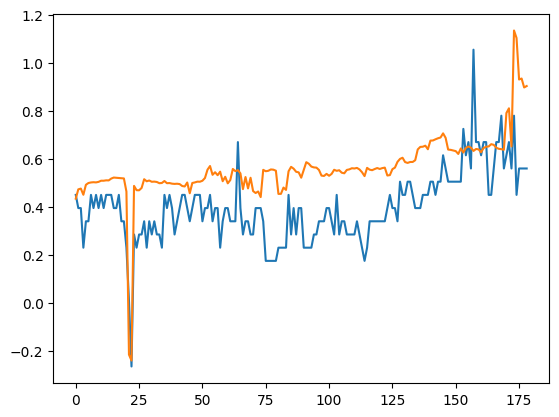